# Homework 2: DDPM

## Section A

In this section, we will implement DDPM (**Denoising Diffusion Probabilistic Models**) on a simple 1D Mixture of Gaussians Model.

Note that GPUs will not help in any part except the final section with the generation of images (everything else runs in less than a second), so it is recommended to run this part of the homework on a local CPU.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal, kl_divergence

import seaborn as sns
import itertools
from tqdm.auto import tqdm

A Gaussian Mixture Model is a distribution that is the combination of several Gaussian distributions, such as the following:

$$
X | Y \sim \mathcal{N}(\mu_1, \sigma_1 I)Y + \mathcal{N}(\mu_2, \sigma_2 I)(1 - Y)
$$

where $Y \sim \text{Ber}(p)$. In our case, $X \in \mathbb{R}^1$.

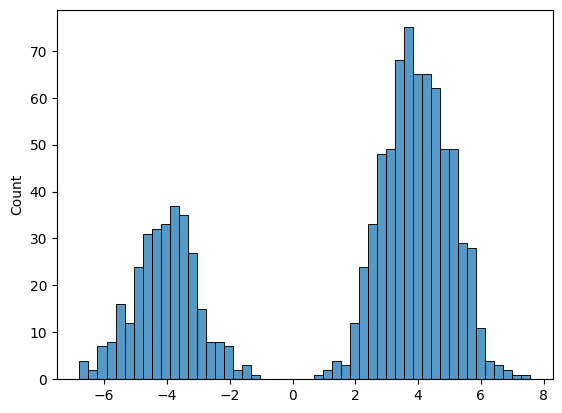

In [2]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0], bins=50)
plt.show()


In [3]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = 0.02
ALPHA = 1 - BETA
ALPHA_BAR = [ALPHA ** i for i in range(TIME_STEPS+1)]

Pay attention - beta is constant, hence $x_{t+1}$ is sampled from $q_t = \N(\sqrt{1-\beta}x_t, \sqrt{\beta})$

Implement the following functions to perform ddpm and restore the original given distribution. You can add any other functions required.

In [4]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    ''''
    perform diffusion following equation 2
    returns a list of q(x(t)) and x(t)
    starting from t=0 (i.e., the dataset)
    
    :param data: torch.Size([1000, 1])
    :return samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :return distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    '''


    distributions, samples = [None], [data]
    xt = data # = data_distribution.sample(torch.Size([1000, 1]))
        
    #### ADD YOUR CODE HERE ####
    for t in range(1, steps + 1):
        mean = torch.sqrt(torch.tensor(1 - beta)) * xt
        std = torch.sqrt(torch.tensor(beta))
        
        dist = Normal(mean, std)
        xt = dist.rsample()  # draw next x_t
        distributions.append(dist)
        samples.append(xt)

    #### DONE WITH SOLUTION ####     

    return distributions, samples 

Sample and visualize realizations of the forward/diffusion process over time, using samples from do_diffusion(dataset)

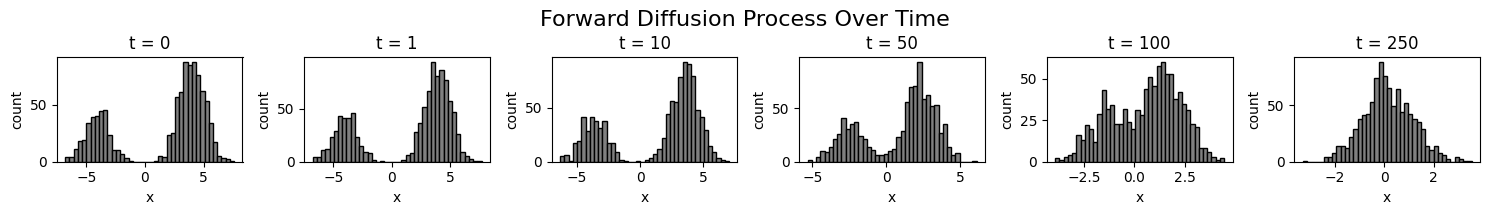

In [5]:
_, samples = do_diffusion(dataset)

#### ADD YOUR CODE HERE ####
timesteps_to_plot = [0, 1, 10, 50, 100, 250]  # t=0 is original, t=250 is most noisy
num_plots = len(timesteps_to_plot)
plt.figure(figsize=(15, 2))

for i, t in enumerate(timesteps_to_plot):
    plt.subplot(1, num_plots, i + 1)
    plt.hist(samples[t].detach().numpy(), bins=40, color='gray', edgecolor='black')
    plt.title(f"t = {t}")
    plt.xlabel("x")
    plt.ylabel("count")
    plt.tight_layout()

plt.suptitle("Forward Diffusion Process Over Time", y=1.05, fontsize=16)
plt.show()
#### DONE WITH SOLUTION #### 

# Training
We first use the loss in Equation 3 in the paper without any of the optimizations presented later, which a play significant role for complex, real-world distributions.

Diffusion models are trained by first corrupting the training examples, then trying to reconstruct the cleaner examples from the noisy examples at each step of the corruption process. The loss is an upper bound on the negative log likelihood:

$L := \mathbb{E}_q\left[
-\log p(x_T)
-\sum_{t=1}^T \log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} 
\right]$

Where the generative model, also called reverse process, has form:

$p_\theta(x_{t-1}|x_t):=\mathcal{N}(x_{t-1} ; \mu_\theta(x_t,t), \Sigma_\theta(x_t, t))$

Note that we are training two neural networks, $\mu_\theta$ and $\Sigma_\theta$, which take as input a noisy sample $x_t$ and the step $t$, and try to predict the parameters of the distribution of the sample $x_{t-1}$ to which noise was added. Intuitively, we are training these networks to maximize the predicted probability of observing the uncorrputed example $x_{t-1}$ based on $x_t$ , i.e., the term $p_\theta(x_{t-1}\vert x_t)$ in the loss, for each diffusion step. Remember that $x_t$ was generated earlier from $x_{t-1}$ by adding noise; the networks have to learn to undo the noise. The other terms in the loss involving $q(x_t\vert x_{t-1})$ are not necessary to learn a good generative model, since they are constant, but are useful as a “frame of reference” to make a “perfect” generative model achieve a loss of 0.

You should implement the loss in the function below. This function requires the entire diffusion trajectory for the training samples, as well as the two neural networks that define the inverse process:

In [6]:
def compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model):
    """
    Compute the loss in equation 3
    forward = q , reverse = p

    :param forward_distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :return: averaged loss over total TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####
    T = len(forward_samples) - 1  # TIME_STEPS
    total_kl = 0.0

    for t in range(1, T + 1):
        x_t = forward_samples[t]
        x_t_minus_1 = forward_samples[t - 1]
        
        q_dist = forward_distributions[t]
    
        # Create time tensor
        t_tensor = torch.full_like(x_t, t)  # shape [1000, 1]
    
        # Call models with both x_t and t
        mu_theta = mean_model(x_t, t_tensor)
        std_theta = torch.exp(0.5 * var_model(x_t, t_tensor))
        
        p_dist = Normal(mu_theta, std_theta)
        kl = kl_divergence(q_dist, p_dist)
        total_kl += kl.mean()

    # We typically drop -log p(x_T) since x_T is pure noise (constant entropy)
    return total_kl / T
    #### DONE WITH SOLUTION #### 


We also implement and use the loss in Equation 12 in the paper with the suggested optimizations presented.

In [7]:
def compute_loss_equation12(forward_samples, noise_model):
    """
    Compute the loss in equation 12
    forward = q , reverse = p
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param noise_model: torch.nn.Module
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####
    x0 = forward_samples[0]
    T = len(forward_samples) - 1

    loss = 0.0
    for t in range(1, T + 1):
        batch_size = x0.shape[0]

        beta_t = BETA
        alpha_t = ALPHA
        alpha_bar_t = ALPHA_BAR[t]
        sigma_t2 = beta_t  # for fixed variance case

        sqrt_alpha_bar = torch.sqrt(torch.tensor(alpha_bar_t))
        sqrt_one_minus_alpha_bar = torch.sqrt(torch.tensor(1 - alpha_bar_t))

        # Sample true noise
        epsilon = torch.randn_like(x0)

        # Sample x_t from q(x_t | x_0)
        xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * epsilon

        # Predict noise with model
        predicted_epsilon = noise_model(xt, torch.tensor([t] * batch_size).unsqueeze(1).float())

        # Weight from Equation 12
        weight = (beta_t ** 2) / (2 * sigma_t2 * alpha_t * (1 - alpha_bar_t +0.005))
        
        loss += weight * torch.mean((epsilon - predicted_epsilon) ** 2)

    return loss / T
    #### DONE WITH SOLUTION #### 


In [8]:
def compute_loss(equation, forward_distributions, forward_samples, mean_model, var_model, noise_model):
    """
    Compute the loss according to the given equation (just a wrapper)
    :param equation: int
    :param forward_distributions: list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    :param forward_samples: list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :return: averaged loss over TIME_STEPS
    """
    #### ADD YOUR CODE HERE ####
    if equation == 3:
        if mean_model is None or var_model is None:
            raise ValueError("mean_model and var_model must be provided for equation 3.")
        return compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model)

    elif equation == 12:
        if noise_model is None:
            raise ValueError("noise_model must be provided for equation 12.")
        return compute_loss_equation12(forward_samples, noise_model)

    else:
        raise ValueError(f"Unsupported equation: {equation}. Only 3 and 12 are supported.")
    #### DONE WITH SOLUTION #### 

Now define three very simple neural networks to predict the mean/variance/noise, and an optimizer.

These networks take two inputs: the noisy sample $x_t$ and the normalized time-step t. The time-step is added as an additional column feature, and, since the input is also one-dimensional, the total input size is two.

When you are happy with your simple model architecure, show the training curve for both equations.

In [9]:
#### ADD YOUR CODE HERE ####

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        t = t.float() / TIME_STEPS  # normalize t to [0, 1]
        t = t.expand_as(x)
        input = torch.cat([x, t], dim=1)  # shape [batch, 2]
        return self.net(input)



#### DONE WITH SOLUTION #### 

In [10]:
def train_loop(dataset, mean_model, var_model, noise_model, optim,equation=3):    
    """
    Train the model
    :param dataset: torch.Size([1000, 1])
    :param mean_model: Optinal(torch.nn.Module) = None
    :param var_model: Optinal(torch.nn.Module) = None
    :param noise_model: Optinal(torch.nn.Module) = None
    :param optim: torch.optim
    :return: list of losses by epoch
    """
    loss_history = []
    bar = tqdm(range(300))
    #### ADD YOUR CODE HERE ####
    for _ in bar:
        # Run diffusion
        forward_distributions, forward_samples = do_diffusion(dataset)

        # Zero gradients
        optim.zero_grad()

        # Compute loss
        loss = compute_loss(
            equation,
            forward_distributions,
            forward_samples,
            mean_model=mean_model,
            var_model=var_model,
            noise_model=noise_model
        )

        # Backprop and step
        loss.backward()
        optim.step()

        # Track and show loss
        loss_value = loss.item()
        bar.set_description(f"Loss: {loss_value:.4f}")
        loss_history.append(loss_value)

    #### DONE WITH SOLUTION ####    

    return loss_history    




In [11]:
mean_model = SimpleMLP()
var_model = SimpleMLP()
noise_model = SimpleMLP()
optimizer1 = torch.optim.Adam(list(mean_model.parameters()) + list(var_model.parameters()), lr=1e-3)
loss_history_eq3 = train_loop(dataset, mean_model, var_model, noise_model, optimizer1,equation=3)

  0%|          | 0/300 [00:00<?, ?it/s]

In [12]:
optimizer2 = torch.optim.Adam(noise_model.parameters(), lr=1e-3)
loss_history_eq12 = train_loop(dataset, None, None, noise_model, optimizer2, equation=12)


  0%|          | 0/300 [00:00<?, ?it/s]

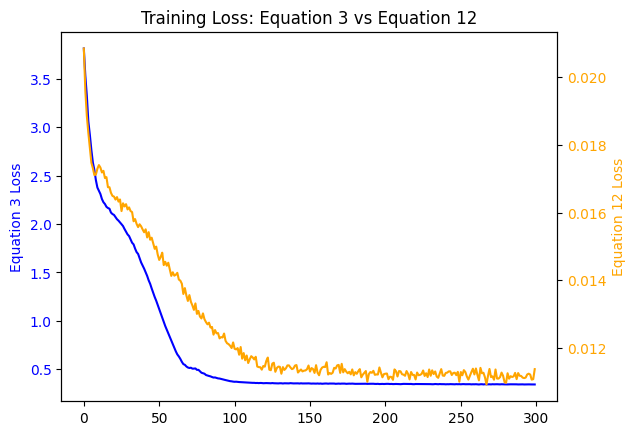

In [13]:


fig, ax1 = plt.subplots()

ax1.plot(loss_history_eq3, label="Equation 3 Loss", color='blue')
ax1.set_ylabel("Equation 3 Loss", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(loss_history_eq12, label="Equation 12 Loss", color='orange')
ax2.set_ylabel("Equation 12 Loss", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Training Loss: Equation 3 vs Equation 12")
plt.xlabel("Epoch")
plt.show()

In [14]:
def save_model(model, filepath):
    """
    Save the PyTorch model to a file.
    
    Args:
        model (torch.nn.Module): The PyTorch model to save.
        filepath (str): The path to save the model file.
    """
    torch.save(model.state_dict(), filepath)
    print("Model saved successfully.")

def load_model(model_class, filepath):
    """
    Load a PyTorch model from a file.
    
    Args:
        model_class (torch.nn.Module): The class of the PyTorch model to load.
        filepath (str): The path to the saved model file.
        
    Returns:
        model (torch.nn.Module): The loaded PyTorch model.
    """
    model_type = filepath.split("/")[-1].split("_")[0]
    #### ADD YOUR CODE HERE ####
    model = SimpleMLP()
    #### DONE WITH SOLUTION ####  
      
    model.load_state_dict(torch.load(filepath), strict=False)
    model.eval()
    print("Model loaded successfully.")
    return model

# save_model(mean_model, "models/mean_model.pth")
# save_model(var_model, "models/var_model.pth")
# save_model(noise_model, "models/noise_model.pth")


# mean_model = load_model(torch.nn.Sequential, "models/mean_model.pth")
# var_model = load_model(torch.nn.Sequential, "models/var_model.pth")
# noise_model = load_model(torch.nn.Sequential, "models/noise_model.pth")

# Sampling
Implement the original paper's sampling procedure, for both equations 3,12

In [15]:
def sample_reverse_equation3(mean_model, var_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 3
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####
    sample_history = []
    
    xt = torch.randn(count, 1)  # start from x_T ~ N(0, I)
    sample_history.append(xt)

    for t in reversed(range(1, steps + 1)):
        t_tensor = torch.full((count, 1), t, dtype=torch.float32)
        
        mu = mean_model(xt, t_tensor)
        log_var = var_model(xt, t_tensor)
        std = torch.exp(0.5 * log_var)

        # Sample from p(x_{t-1} | x_t)
        noise = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)
        xt = mu + std * noise
        sample_history.append(xt)
    #### DONE WITH SOLUTION ####
    return sample_history

def sample_reverse_equation12(noise_model, count, steps=TIME_STEPS):
    """
    Sample from the reverse process using equation 12
    :param noise_model: torch.nn.Module
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####
    sample_history = []

    xt = torch.randn(count, 1)  # Start from noise
    sample_history.append(xt)

    for t in reversed(range(1, steps + 1)):
        alpha_t = ALPHA
        alpha_bar_t = ALPHA_BAR[t]
        beta_t = BETA
        sigma_t = torch.sqrt(torch.tensor(beta_t))

        t_tensor = torch.full((count, 1), t, dtype=torch.float32)
        eps_theta = noise_model(xt, t_tensor)

        # Compute x_{t-1}
        coeff = (1 - alpha_t) / torch.sqrt(torch.tensor(1 - alpha_bar_t))
        xt_mean = (1 / torch.sqrt(torch.tensor(alpha_t))) * (xt - coeff * eps_theta)

        noise = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)
        xt = xt_mean + sigma_t * noise
        sample_history.append(xt)

    #### DONE WITH SOLUTION ####    
        
    return sample_history

In [16]:
def sample_reverse(equation, mean_model, var_model, noise_model, count, steps=250): #change from 1000 to 250 that will align with the parameter 'TIME_STEPS'
    """
    Sample from the reverse process using the given equation, it's a wrapper
    :param equation: int
    :param mean_model: Optional(torch.nn.Module)=None
    :param var_model: Optional(torch.nn.Module)=None
    :param noise_model: Optional(torch.nn.Module)=None
    :param count: int
    :param steps: int
    :return: sample_history, a list of torch.Size([count, 1]) samples
    """
    #### ADD YOUR CODE HERE ####
    if equation == 3:
        if mean_model is None or var_model is None:
            raise ValueError("mean_model and var_model are required for equation 3.")
        return sample_reverse_equation3(mean_model, var_model, count, steps)

    elif equation == 12:
        if noise_model is None:
            raise ValueError("noise_model is required for equation 12.")
        return sample_reverse_equation12(noise_model, count, steps)

    else:
        raise ValueError("Unsupported equation. Must be 3 or 12.")
    #### DONE WITH SOLUTION ####

Show us your reverse sampling, x axis is time, y axis it the sampled process realization value.

Afterwards, compare the original distribution, with each of the estimated distributions, seperatly. 

Add at the end of this section, where do you think the diffrence between the FIDs and the charts is coming from.

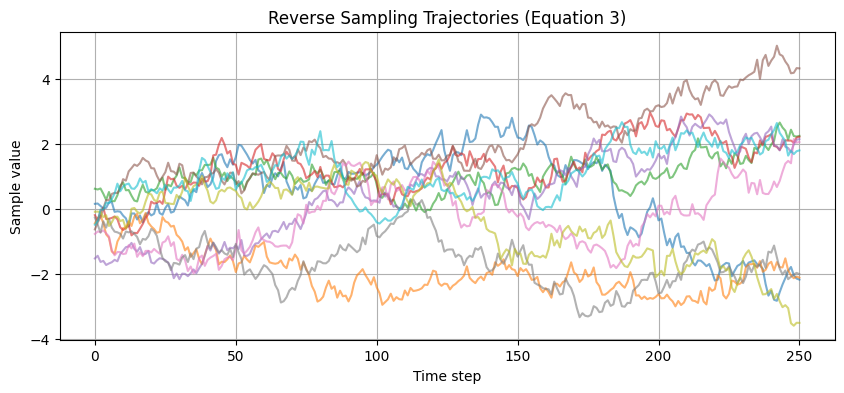

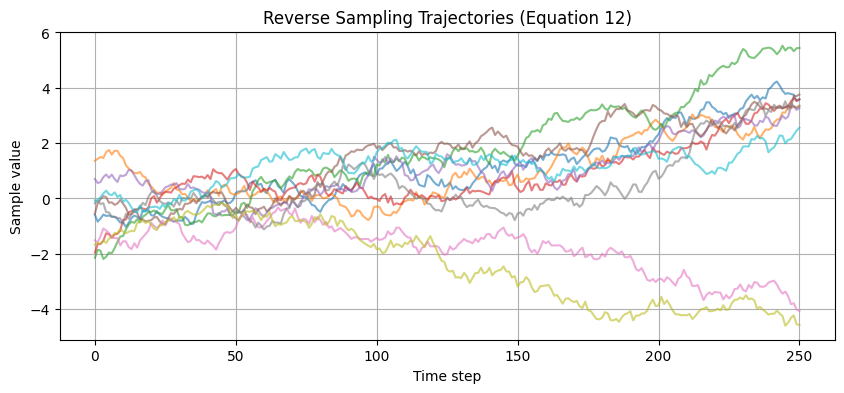

In [29]:
#### ADD YOUR CODE HERE ####
#sampling
samples_eq3 = sample_reverse(3, mean_model=mean_model, var_model=var_model, noise_model=None, count=1000)
samples_eq12 = sample_reverse(12, mean_model=None, var_model=None, noise_model=noise_model, count=1000)

samples_eq3 = torch.stack(samples_eq3, dim=0).squeeze(-1).detach()  # [steps+1, count]
samples_eq12 = torch.stack(samples_eq12, dim=0).squeeze(-1).detach()

# === 3. Plot reverse sample trajectories ===
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.plot(range(len(samples_eq3)), samples_eq3[:, i].numpy(), alpha=0.6)
plt.title("Reverse Sampling Trajectories (Equation 3)")
plt.xlabel("Time step")
plt.ylabel("Sample value")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.plot(range(len(samples_eq12)), samples_eq12[:, i].numpy(), alpha=0.6)
plt.title("Reverse Sampling Trajectories (Equation 12)")
plt.xlabel("Time step")
plt.ylabel("Sample value")
plt.grid(True)
plt.show()




#### DONE WITH SOLUTION ####

These are 10 sample that were tested for each of the losses

In [18]:
import numpy as np
from scipy.linalg import sqrtm

#define helper function for the FID calculation
def calculate_fid(mu1, sigma1, mu2, sigma2):
    """Frechet Distance between two Gaussians."""
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    cov_sqrt = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    return np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * cov_sqrt)

def compare_fid(data_distribution, mean_model, var_model, noise_model, count=10000):
    """
    Calculate the Frechet Inception Distance (FID) between the target distribution and the generated samples, uzilizing scipy.linalg.sqrtm
    :param data_distribution: torch.distributions.mixture_same_family.MixtureSameFamily
    :param mean_model: torch.nn.Module
    :param var_model: torch.nn.Module
    :param noise_model: torch.nn.Module
    :param count: int
    """
    
    original_samples = data_distribution.sample(torch.Size([10000, 1]))  # from your target distribution
    generated_samples_3 =  torch.stack(sample_reverse(3, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model
    generated_samples_12 =  torch.stack(sample_reverse(12, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model

    #### ADD YOUR CODE HERE ####
    # Compute means and covariances
    mu_r = np.mean(original_samples.numpy(), axis=0)
    sigma_r = np.cov(original_samples.numpy().T)
    
    mu_g3 = np.mean(generated_samples_3.detach().numpy(), axis=0)
    sigma_g3 = np.cov(generated_samples_3.detach().numpy().T)
    
    mu_g12 = np.mean(generated_samples_12.detach().numpy(), axis=0)
    sigma_g12 = np.cov(generated_samples_12.detach().numpy().T)

    fid_eq3 = calculate_fid(mu_r, sigma_r, mu_g3, sigma_g3)
    fid_eq12 = calculate_fid(mu_r, sigma_r, mu_g12, sigma_g12)


    print(f"FID (Equation 3):   {fid_eq3:.4f}")
    print(f"FID (Equation 12):  {fid_eq12:.4f}")
        
    #### DONE WITH SOLUTION ####    


compare_fid(data_distribution, mean_model, var_model, noise_model, count=10000)

FID (Equation 3):   1.8695
FID (Equation 12):  0.0043


## ADD YOUR HYPOTHESIS REGARDING THE DIFFRENCE HERE - Change this cell into Markdown ##
FID measures how similar the full structure of the generated data is to the real data, including sharpness and diversity. Equation 12 directly predicts noise and often produces sharper, cleaner samples, while Equation 3 may produce blurrier results. This difference in visual quality leads to a much lower FID for Equation 12.
#### DONE WITH SOLUTION ####

## Section B

In this section, we will implement DDPM on multidimentional, unknown distribution.
Same as in previous section, will be based on the original DDPM paper by ([Ho et al., 2020](https://arxiv.org/abs/2006.11239))

In [30]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

### Network helpers

In [31]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    """
    simply adds the input to the output of a particular function
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$.


In [33]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings, as described in the paper
    """

    def __init__(self, dim):
        """
        :param dim: int, the dimension of the embeddings
        """
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        :param time: torch Tenseor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, dim)
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block.

In [34]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. 


In [35]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization.

In [36]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + a downsample operation
* at the middle of the network, again ResNet blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + an upsample operation
* finally, a ResNet block followed by a convolutional layer is applied.

Watch carefully every element of this architecture, what it is doing, which input shape and output shape it has.

In [37]:
class Unet(nn.Module):
    """
    Unet architecture for diffusion models
    the network takes a batch of noisy images of shape (batch_size, num_channels, height, width) 
    and a batch of noise levels of shape (batch_size, 1) as input
    and returns a tensor of shape (batch_size, num_channels, height, width)
    """
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=1
    ):
        super().__init__()

        #### ADD YOUR CODE HERE ####

        self.channels = channels
        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.SiLU(),
                nn.Linear(time_dim, time_dim)
            )
        else:
            time_dim = None
            self.time_mlp = None

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                ResnetBlock(dim_out, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else nn.Identity()
            ]))

        out_dim = default(out_dim, channels)
        self.final_block = ResnetBlock(dim, dim, groups=resnet_block_groups)
        self.final_conv = nn.Conv2d(dim, out_dim, 1)
        #### DONE WITH SOLUTION ####

    def forward(self, x, time):
        """
        :param x: torch Tensor of shape (batch_size, channels, height, width)
        :param time: torch Tensor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, channels, height, width)
        """

        #### ADD YOUR CODE HERE ####
        t = self.time_mlp(time) if exists(self.time_mlp) else None

        x = self.init_conv(x)
        h = []

        for resnet1, resnet2, attn, downsample in self.downs:
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for resnet1, resnet2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = attn(x)
            x = upsample(x)

        x = self.final_block(x, t)
        return self.final_conv(x)

        #### DONE WITH SOLUTION ####

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$, according to a **variance schedule**.

Implement both.

In [38]:
def linear_beta_schedule(timesteps):
    """
    set the forward process variances to constants
    increasing linearly from beta_1 = 0.0001 to beta_T = 0.02.
    :param timesteps: int
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####
    beta_start = 0.0001
    beta_end = 0.02
    #### DONE WITH SOLUTION ####
    return torch.linspace(beta_start, beta_end, timesteps)
    

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672))
    :param timesteps: int
    :param s: float
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # normalize

    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    #### DONE WITH SOLUTION ####
    return torch.clip(betas, 0.0001, 0.9999)
    

To start with, let's use the linear schedule for $T=200$ time steps.

Define the variables $\beta_t$, $\alpha_t$ for each $t$, the cumulative product of the variances $\bar{\alpha}_t$, and every other variable that is helpful.

Each should be a 1-dimensional tensors, storing values from $t$ to $T$. Later use the extact function to extract the appropriate $t$ index for a batch of indices.


In [237]:

timesteps = 500

# define beta schedule (adjust to timesteps - 1, then prepend)
betas = linear_beta_schedule(timesteps=timesteps - 1)
betas = torch.cat([torch.tensor([0.0]), betas])  # ensure beta[0] = 0

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod, (1, 0), value=1.0)[:-1]  # aligned length
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# helper function
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(0, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


From the DPPM paper:

> We assume that image data consists of integers in $\{0, 1, ... , 255\}$ scaled linearly to $[−1, 1]$. This
ensures that the neural network reverse process operates on consistently scaled inputs starting from
the standard normal prior $p(\mathbf{x}_T )$.


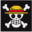

In [238]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np
from PIL import Image
import requests

image_size = 32
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

url = 'https://makerworld.bblmw.com/makerworld/model/USccdf23715faced/design/2024-03-31_9dc4bf51fa8e3.png?x-oss-process=image/resize,w_1000/format,webp'
image = Image.open(requests.get(url, stream=True).raw)
x_start = transform(image).unsqueeze(0)
x_start.shape
reverse_transform(x_start.squeeze())


### Forward/ Diffusion process ###

In [239]:
# forward diffusion q(x_t | x_0)
def q_sample(x_start, t, noise=None):
    """
    q_sample function for diffusion process
    :param x_start: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param noise: Optional(torch.Tensor) = None
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####
    if noise is None:
        noise = torch.randn_like(x_start)
    
    sqrt_alpha_bar_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alpha_bar_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise
    #### DONE WITH SOLUTION ####

Test your result on a particular time step:

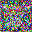

In [240]:
def get_noisy_image(x_start, t):
  # add noise
  batch_size = x_start.shape[0]
    
  # Convert scalar t to shape (batch_size, 1)
  t_tensor = torch.full((batch_size,), t, dtype=torch.long, device=x_start.device)
  x_noisy = q_sample(x_start, t=t_tensor)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze(0).cpu())

  return noisy_image

#### ADD YOUR CODE HERE ####
timestep = 100  

# Generate a noisy image
noisy_img = get_noisy_image(x_start, t=timestep)

display(noisy_img)

#### DONE WITH SOLUTION ####

Now visualize this for various time steps:

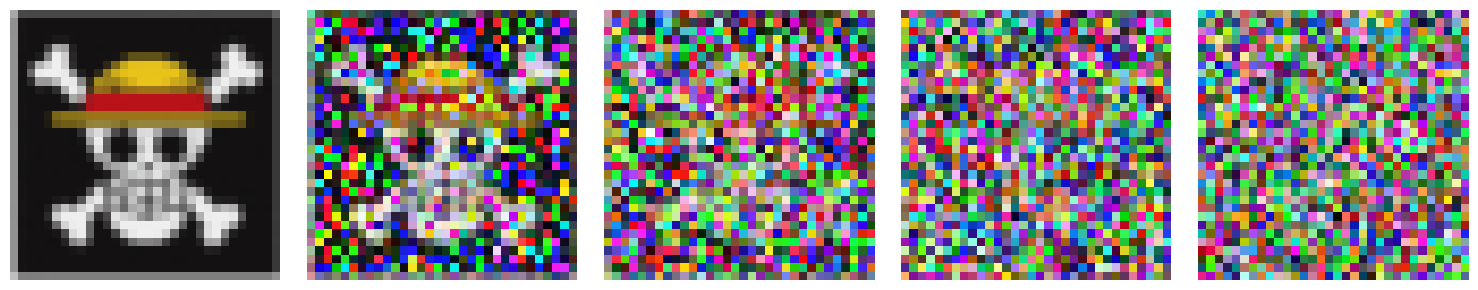

In [241]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

#### ADD YOUR CODE HERE ####
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Plot a list of images in a grid.
    :param imgs: list of images to plot
    :param with_orig: bool, whether to include the original image
    :param row_title: list of titles for each row
    :param imshow_kwargs: additional arguments for imshow
    """
    num_imgs = len(imgs)
    plt.figure(figsize=(3 * num_imgs, 3))
    
    for i, img in enumerate(imgs):
        plt.subplot(1, num_imgs, i + 1)
        plt.imshow(img, **imshow_kwargs)
        plt.axis("off")
        if row_title:
            plt.title(row_title[i])
    
    plt.tight_layout()
    plt.show()
#### DONE WITH SOLUTION ####

plot([get_noisy_image(x_start, t) for t in [0, 50, 100, 150, 199]])


Define the loss function given the model. Use the U-Net defined above.


In [242]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    #### ADD YOUR CODE HERE ####
    # Sample noisy image at timestep t
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    # Predict noise using the denoising model
    predicted_noise = denoise_model(x_noisy, t)
    #### DONE WITH SOLUTION ####

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Define a PyTorch Dataset + DataLoader

The dataset is Fashion-MNIST, to easily load the Fashion MNIST dataset from the [hub](https://huggingface.co/datasets/fashion_mnist). 
The images suppose to be 28x28 grayscale images, scaled linearly to $[-1, 1]$.

Implement a PyTorch Dataset class that loads the images and applies wanted transformations on-the-fly, and a DataLoader to load the dataset in batches.


In [243]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

#### ADD YOUR CODE HERE ####
from PIL import Image

# Define transform: resize if needed, convert to tensor, scale to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),                      # [0, 255] → [0, 1]
    transforms.Lambda(lambda x: x * 2 - 1),     # [0, 1] → [-1, 1]
])

# Custom PyTorch dataset using Hugging Face's Fashion-MNIST
class FashionMNISTDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.dataset = load_dataset("fashion_mnist", split=split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        if self.transform:
            image = self.transform(image)
        return image

# Create DataLoader
batch_size = 128
train_dataset = FashionMNISTDataset(split='train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#### DONE WITH SOLUTION ####


## Sampling

Implement sampling algorithm 2 from the original paper: 

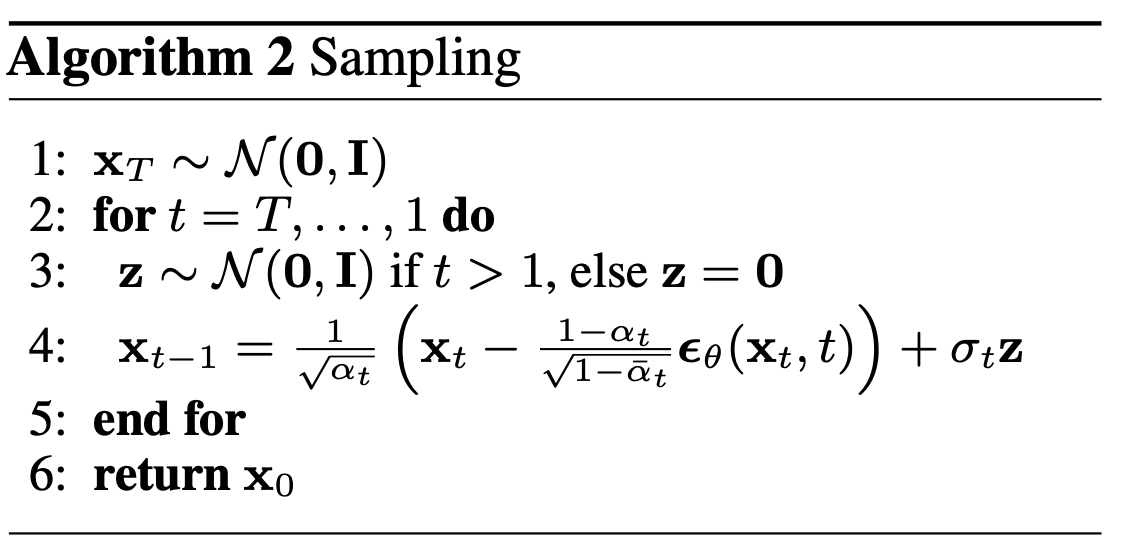

In [244]:

@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    p_sample function for reverse process
    :param model: torch.nn.Module
    :param x: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param t_index: int
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####
    # Predict the noise εθ(x_t, t)
    predicted_noise = model(x, t)

    # Get required constants
    betas_t = extract(betas, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)

    # Compute model mean: x_{t-1} = 1/√α_t (x_t - β_t / √(1-ᾱ_t) * εθ(x_t, t))
    model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
    #### DONE WITH SOLUTION ####

    if t_index == 0:
        return model_mean
    else:
        #### ADD YOUR CODE HERE ####
        posterior_var_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_var_t) * noise
        #### DONE WITH SOLUTION ####


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        # img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        t = torch.full((b,), i, device=device, dtype=torch.long)  # [B]
        img = p_sample(model, img, t, i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



## Train the model

Implement training algorithm 1 from the original paper: 

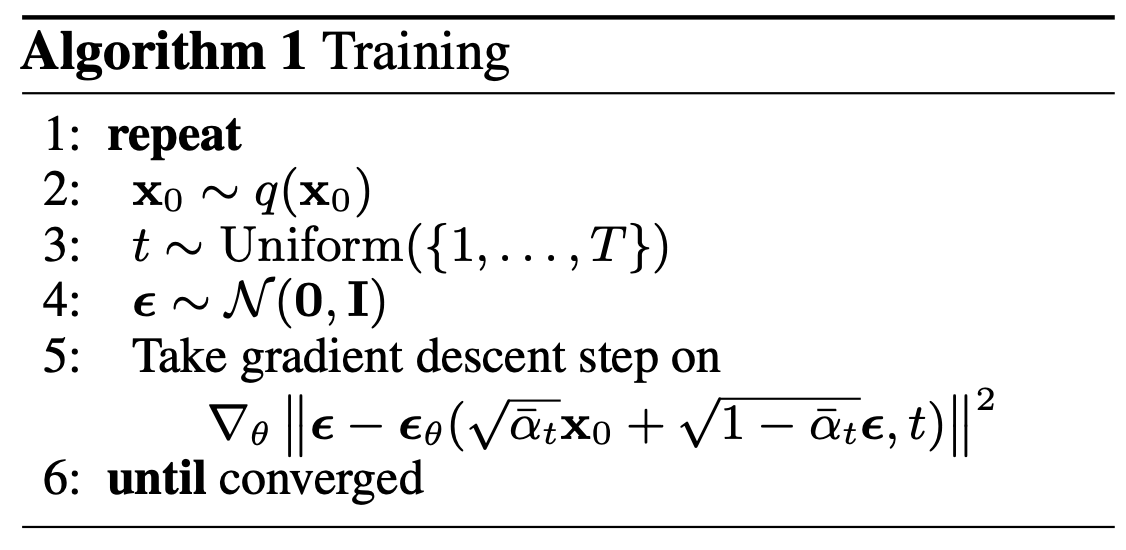

In [250]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
channels = 1
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [251]:
from torchvision.utils import save_image
from pathlib import Path

#### ADD YOUR CODE HERE ####
epochs = 60
model.train()

for epoch in range(epochs):
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}")

    for step, batch in pbar:
        batch = batch.to(device)

        # Sample random timestep t
        t = torch.randint(0, timesteps, (batch.size(0),), device=device).long()
        
        # Compute loss (Algorithm 1)
        loss = p_losses(model, batch, t, loss_type="l2")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())


        if step % 100 == 0:
            # print(f"Epoch {epoch+1} | Step {step} | Loss: {loss.item():.4f}")
            pbar.write(f"Epoch {epoch+1} | Step {step} | Loss: {loss.item():.4f}")


#### DONE WITH SOLUTION ####        

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 | Step 0 | Loss: 1.8104
Epoch 1 | Step 100 | Loss: 0.1769
Epoch 1 | Step 200 | Loss: 0.1671
Epoch 1 | Step 300 | Loss: 0.1072
Epoch 1 | Step 400 | Loss: 0.1117


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Step 0 | Loss: 0.0882
Epoch 2 | Step 100 | Loss: 0.0795
Epoch 2 | Step 200 | Loss: 0.1105
Epoch 2 | Step 300 | Loss: 0.0940
Epoch 2 | Step 400 | Loss: 0.0957


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Step 0 | Loss: 0.0667
Epoch 3 | Step 100 | Loss: 0.0774
Epoch 3 | Step 200 | Loss: 0.0774
Epoch 3 | Step 300 | Loss: 0.0769
Epoch 3 | Step 400 | Loss: 0.0655


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Step 0 | Loss: 0.0634
Epoch 4 | Step 100 | Loss: 0.0663
Epoch 4 | Step 200 | Loss: 0.0578
Epoch 4 | Step 300 | Loss: 0.0787
Epoch 4 | Step 400 | Loss: 0.0712


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Step 0 | Loss: 0.0677
Epoch 5 | Step 100 | Loss: 0.0684
Epoch 5 | Step 200 | Loss: 0.0619
Epoch 5 | Step 300 | Loss: 0.0559
Epoch 5 | Step 400 | Loss: 0.0638


Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 | Step 0 | Loss: 0.0685
Epoch 6 | Step 100 | Loss: 0.0671
Epoch 6 | Step 200 | Loss: 0.0544
Epoch 6 | Step 300 | Loss: 0.0647
Epoch 6 | Step 400 | Loss: 0.0543


Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 | Step 0 | Loss: 0.0630
Epoch 7 | Step 100 | Loss: 0.0533
Epoch 7 | Step 200 | Loss: 0.0557
Epoch 7 | Step 300 | Loss: 0.0627
Epoch 7 | Step 400 | Loss: 0.0652


Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 | Step 0 | Loss: 0.0633
Epoch 8 | Step 100 | Loss: 0.0643
Epoch 8 | Step 200 | Loss: 0.0714
Epoch 8 | Step 300 | Loss: 0.0494
Epoch 8 | Step 400 | Loss: 0.0735


Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 | Step 0 | Loss: 0.0693
Epoch 9 | Step 100 | Loss: 0.0427
Epoch 9 | Step 200 | Loss: 0.0524
Epoch 9 | Step 300 | Loss: 0.0656
Epoch 9 | Step 400 | Loss: 0.0670


Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 | Step 0 | Loss: 0.0609
Epoch 10 | Step 100 | Loss: 0.0749
Epoch 10 | Step 200 | Loss: 0.0701
Epoch 10 | Step 300 | Loss: 0.0557
Epoch 10 | Step 400 | Loss: 0.0593


Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11 | Step 0 | Loss: 0.0558
Epoch 11 | Step 100 | Loss: 0.0484
Epoch 11 | Step 200 | Loss: 0.0603
Epoch 11 | Step 300 | Loss: 0.0580
Epoch 11 | Step 400 | Loss: 0.0609


Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12 | Step 0 | Loss: 0.0772
Epoch 12 | Step 100 | Loss: 0.0599
Epoch 12 | Step 200 | Loss: 0.0552
Epoch 12 | Step 300 | Loss: 0.0688
Epoch 12 | Step 400 | Loss: 0.0587


Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13 | Step 0 | Loss: 0.0521
Epoch 13 | Step 100 | Loss: 0.0440
Epoch 13 | Step 200 | Loss: 0.0745
Epoch 13 | Step 300 | Loss: 0.0557
Epoch 13 | Step 400 | Loss: 0.0630


Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14 | Step 0 | Loss: 0.0516
Epoch 14 | Step 100 | Loss: 0.0464
Epoch 14 | Step 200 | Loss: 0.0528
Epoch 14 | Step 300 | Loss: 0.0594
Epoch 14 | Step 400 | Loss: 0.0628


Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15 | Step 0 | Loss: 0.0534
Epoch 15 | Step 100 | Loss: 0.0529
Epoch 15 | Step 200 | Loss: 0.0491
Epoch 15 | Step 300 | Loss: 0.0491
Epoch 15 | Step 400 | Loss: 0.0642


Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16 | Step 0 | Loss: 0.0483
Epoch 16 | Step 100 | Loss: 0.0667
Epoch 16 | Step 200 | Loss: 0.0542
Epoch 16 | Step 300 | Loss: 0.0544
Epoch 16 | Step 400 | Loss: 0.0529


Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 | Step 0 | Loss: 0.0656
Epoch 17 | Step 100 | Loss: 0.0561
Epoch 17 | Step 200 | Loss: 0.0528
Epoch 17 | Step 300 | Loss: 0.0412
Epoch 17 | Step 400 | Loss: 0.0757


Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18 | Step 0 | Loss: 0.0438
Epoch 18 | Step 100 | Loss: 0.0499
Epoch 18 | Step 200 | Loss: 0.0517
Epoch 18 | Step 300 | Loss: 0.0598
Epoch 18 | Step 400 | Loss: 0.0539


Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19 | Step 0 | Loss: 0.0616
Epoch 19 | Step 100 | Loss: 0.0589
Epoch 19 | Step 200 | Loss: 0.0562
Epoch 19 | Step 300 | Loss: 0.0537
Epoch 19 | Step 400 | Loss: 0.0654


Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20 | Step 0 | Loss: 0.0509
Epoch 20 | Step 100 | Loss: 0.0500
Epoch 20 | Step 200 | Loss: 0.0598
Epoch 20 | Step 300 | Loss: 0.0774
Epoch 20 | Step 400 | Loss: 0.0645


Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21 | Step 0 | Loss: 0.0642
Epoch 21 | Step 100 | Loss: 0.0616
Epoch 21 | Step 200 | Loss: 0.0537
Epoch 21 | Step 300 | Loss: 0.0438
Epoch 21 | Step 400 | Loss: 0.0671


Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22 | Step 0 | Loss: 0.0496
Epoch 22 | Step 100 | Loss: 0.0491
Epoch 22 | Step 200 | Loss: 0.0520
Epoch 22 | Step 300 | Loss: 0.0706
Epoch 22 | Step 400 | Loss: 0.0828


Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23 | Step 0 | Loss: 0.0442
Epoch 23 | Step 100 | Loss: 0.0425
Epoch 23 | Step 200 | Loss: 0.0505
Epoch 23 | Step 300 | Loss: 0.0594
Epoch 23 | Step 400 | Loss: 0.0430


Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24 | Step 0 | Loss: 0.0669
Epoch 24 | Step 100 | Loss: 0.0620
Epoch 24 | Step 200 | Loss: 0.0642
Epoch 24 | Step 300 | Loss: 0.0626
Epoch 24 | Step 400 | Loss: 0.0541


Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25 | Step 0 | Loss: 0.0539
Epoch 25 | Step 100 | Loss: 0.0625
Epoch 25 | Step 200 | Loss: 0.0506
Epoch 25 | Step 300 | Loss: 0.0481
Epoch 25 | Step 400 | Loss: 0.0304


Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26 | Step 0 | Loss: 0.0479
Epoch 26 | Step 100 | Loss: 0.0535
Epoch 26 | Step 200 | Loss: 0.0421
Epoch 26 | Step 300 | Loss: 0.0654
Epoch 26 | Step 400 | Loss: 0.0579


Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27 | Step 0 | Loss: 0.0502
Epoch 27 | Step 100 | Loss: 0.0515
Epoch 27 | Step 200 | Loss: 0.0545
Epoch 27 | Step 300 | Loss: 0.0616
Epoch 27 | Step 400 | Loss: 0.0537


Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28 | Step 0 | Loss: 0.0517
Epoch 28 | Step 100 | Loss: 0.0421
Epoch 28 | Step 200 | Loss: 0.0492
Epoch 28 | Step 300 | Loss: 0.0395
Epoch 28 | Step 400 | Loss: 0.0721


Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29 | Step 0 | Loss: 0.0423
Epoch 29 | Step 100 | Loss: 0.0638
Epoch 29 | Step 200 | Loss: 0.0557
Epoch 29 | Step 300 | Loss: 0.0508
Epoch 29 | Step 400 | Loss: 0.0540


Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30 | Step 0 | Loss: 0.0794
Epoch 30 | Step 100 | Loss: 0.0508
Epoch 30 | Step 200 | Loss: 0.0384
Epoch 30 | Step 300 | Loss: 0.0572
Epoch 30 | Step 400 | Loss: 0.0526


Epoch 31:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31 | Step 0 | Loss: 0.0658
Epoch 31 | Step 100 | Loss: 0.0483
Epoch 31 | Step 200 | Loss: 0.0515
Epoch 31 | Step 300 | Loss: 0.0410
Epoch 31 | Step 400 | Loss: 0.0602


Epoch 32:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32 | Step 0 | Loss: 0.0436
Epoch 32 | Step 100 | Loss: 0.0456
Epoch 32 | Step 200 | Loss: 0.0495
Epoch 32 | Step 300 | Loss: 0.0665
Epoch 32 | Step 400 | Loss: 0.0522


Epoch 33:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33 | Step 0 | Loss: 0.0587
Epoch 33 | Step 100 | Loss: 0.0535
Epoch 33 | Step 200 | Loss: 0.0498
Epoch 33 | Step 300 | Loss: 0.0775
Epoch 33 | Step 400 | Loss: 0.0517


Epoch 34:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34 | Step 0 | Loss: 0.0800
Epoch 34 | Step 100 | Loss: 0.0597
Epoch 34 | Step 200 | Loss: 0.0486
Epoch 34 | Step 300 | Loss: 0.0530
Epoch 34 | Step 400 | Loss: 0.0525


Epoch 35:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35 | Step 0 | Loss: 0.0427
Epoch 35 | Step 100 | Loss: 0.0583
Epoch 35 | Step 200 | Loss: 0.0466
Epoch 35 | Step 300 | Loss: 0.0464
Epoch 35 | Step 400 | Loss: 0.0535


Epoch 36:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36 | Step 0 | Loss: 0.0496
Epoch 36 | Step 100 | Loss: 0.0519
Epoch 36 | Step 200 | Loss: 0.0458
Epoch 36 | Step 300 | Loss: 0.0419
Epoch 36 | Step 400 | Loss: 0.0721


Epoch 37:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37 | Step 0 | Loss: 0.0501
Epoch 37 | Step 100 | Loss: 0.0527
Epoch 37 | Step 200 | Loss: 0.0525
Epoch 37 | Step 300 | Loss: 0.0487
Epoch 37 | Step 400 | Loss: 0.0474


Epoch 38:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38 | Step 0 | Loss: 0.0480
Epoch 38 | Step 100 | Loss: 0.0599
Epoch 38 | Step 200 | Loss: 0.0536
Epoch 38 | Step 300 | Loss: 0.0532
Epoch 38 | Step 400 | Loss: 0.0493


Epoch 39:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39 | Step 0 | Loss: 0.0492
Epoch 39 | Step 100 | Loss: 0.0630
Epoch 39 | Step 200 | Loss: 0.0479
Epoch 39 | Step 300 | Loss: 0.0565
Epoch 39 | Step 400 | Loss: 0.0565


Epoch 40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40 | Step 0 | Loss: 0.0464
Epoch 40 | Step 100 | Loss: 0.0590
Epoch 40 | Step 200 | Loss: 0.0477
Epoch 40 | Step 300 | Loss: 0.0525
Epoch 40 | Step 400 | Loss: 0.0575


Epoch 41:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41 | Step 0 | Loss: 0.0589
Epoch 41 | Step 100 | Loss: 0.0509
Epoch 41 | Step 200 | Loss: 0.0446
Epoch 41 | Step 300 | Loss: 0.0445
Epoch 41 | Step 400 | Loss: 0.0509


Epoch 42:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42 | Step 0 | Loss: 0.0691
Epoch 42 | Step 100 | Loss: 0.0478
Epoch 42 | Step 200 | Loss: 0.0514
Epoch 42 | Step 300 | Loss: 0.0500
Epoch 42 | Step 400 | Loss: 0.0376


Epoch 43:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43 | Step 0 | Loss: 0.0679
Epoch 43 | Step 100 | Loss: 0.0586
Epoch 43 | Step 200 | Loss: 0.0519
Epoch 43 | Step 300 | Loss: 0.0461
Epoch 43 | Step 400 | Loss: 0.0611


Epoch 44:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44 | Step 0 | Loss: 0.0454
Epoch 44 | Step 100 | Loss: 0.0438
Epoch 44 | Step 200 | Loss: 0.0552
Epoch 44 | Step 300 | Loss: 0.0452
Epoch 44 | Step 400 | Loss: 0.0460


Epoch 45:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45 | Step 0 | Loss: 0.0602
Epoch 45 | Step 100 | Loss: 0.0415
Epoch 45 | Step 200 | Loss: 0.0566
Epoch 45 | Step 300 | Loss: 0.0556
Epoch 45 | Step 400 | Loss: 0.0449


Epoch 46:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46 | Step 0 | Loss: 0.0434
Epoch 46 | Step 100 | Loss: 0.0416
Epoch 46 | Step 200 | Loss: 0.0475
Epoch 46 | Step 300 | Loss: 0.0559
Epoch 46 | Step 400 | Loss: 0.0414


Epoch 47:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47 | Step 0 | Loss: 0.0508
Epoch 47 | Step 100 | Loss: 0.0480
Epoch 47 | Step 200 | Loss: 0.0422
Epoch 47 | Step 300 | Loss: 0.0482
Epoch 47 | Step 400 | Loss: 0.0672


Epoch 48:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48 | Step 0 | Loss: 0.0488
Epoch 48 | Step 100 | Loss: 0.0626
Epoch 48 | Step 200 | Loss: 0.0420
Epoch 48 | Step 300 | Loss: 0.0505
Epoch 48 | Step 400 | Loss: 0.0458


Epoch 49:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49 | Step 0 | Loss: 0.0615
Epoch 49 | Step 100 | Loss: 0.0483
Epoch 49 | Step 200 | Loss: 0.0397
Epoch 49 | Step 300 | Loss: 0.0535
Epoch 49 | Step 400 | Loss: 0.0626


Epoch 50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50 | Step 0 | Loss: 0.0512
Epoch 50 | Step 100 | Loss: 0.0490
Epoch 50 | Step 200 | Loss: 0.0491
Epoch 50 | Step 300 | Loss: 0.0451
Epoch 50 | Step 400 | Loss: 0.0426


Epoch 51:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51 | Step 0 | Loss: 0.0434
Epoch 51 | Step 100 | Loss: 0.0498
Epoch 51 | Step 200 | Loss: 0.0515
Epoch 51 | Step 300 | Loss: 0.0513
Epoch 51 | Step 400 | Loss: 0.0445


Epoch 52:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52 | Step 0 | Loss: 0.0484
Epoch 52 | Step 100 | Loss: 0.0379
Epoch 52 | Step 200 | Loss: 0.0599
Epoch 52 | Step 300 | Loss: 0.0644
Epoch 52 | Step 400 | Loss: 0.0445


Epoch 53:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53 | Step 0 | Loss: 0.0475
Epoch 53 | Step 100 | Loss: 0.0659
Epoch 53 | Step 200 | Loss: 0.0544
Epoch 53 | Step 300 | Loss: 0.0588
Epoch 53 | Step 400 | Loss: 0.0518


Epoch 54:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54 | Step 0 | Loss: 0.0432
Epoch 54 | Step 100 | Loss: 0.0510
Epoch 54 | Step 200 | Loss: 0.0448
Epoch 54 | Step 300 | Loss: 0.0501
Epoch 54 | Step 400 | Loss: 0.0457


Epoch 55:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55 | Step 0 | Loss: 0.0393
Epoch 55 | Step 100 | Loss: 0.0573
Epoch 55 | Step 200 | Loss: 0.0537
Epoch 55 | Step 300 | Loss: 0.0478
Epoch 55 | Step 400 | Loss: 0.0533


Epoch 56:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56 | Step 0 | Loss: 0.0723
Epoch 56 | Step 100 | Loss: 0.0489
Epoch 56 | Step 200 | Loss: 0.0505
Epoch 56 | Step 300 | Loss: 0.0574
Epoch 56 | Step 400 | Loss: 0.0497


Epoch 57:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57 | Step 0 | Loss: 0.0554
Epoch 57 | Step 100 | Loss: 0.0472
Epoch 57 | Step 200 | Loss: 0.0625
Epoch 57 | Step 300 | Loss: 0.0436
Epoch 57 | Step 400 | Loss: 0.0409


Epoch 58:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58 | Step 0 | Loss: 0.0526
Epoch 58 | Step 100 | Loss: 0.0615
Epoch 58 | Step 200 | Loss: 0.0412
Epoch 58 | Step 300 | Loss: 0.0644
Epoch 58 | Step 400 | Loss: 0.0374


Epoch 59:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59 | Step 0 | Loss: 0.0568
Epoch 59 | Step 100 | Loss: 0.0388
Epoch 59 | Step 200 | Loss: 0.0421
Epoch 59 | Step 300 | Loss: 0.0455
Epoch 59 | Step 400 | Loss: 0.0426


Epoch 60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60 | Step 0 | Loss: 0.0434
Epoch 60 | Step 100 | Loss: 0.0603
Epoch 60 | Step 200 | Loss: 0.0476
Epoch 60 | Step 300 | Loss: 0.0445
Epoch 60 | Step 400 | Loss: 0.0544


# Sampling (inference)

To sample from the model, you can just use the sample function defined above.

### Sample at least 64 images for submission.

### The zip file should follow the format "HW\{\#assignment\}\_\{id\}.\{extension\}" (according to the course syllabus).

### Images within the zip should be .png or .jpg.


In [257]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)
#### ADD YOUR CODE HERE ####

# Convert to tensor (sample returns a numpy array)
sample_tensor = torch.tensor(samples[-2])  # last frame: x₀
sample_tensor = sample_tensor.clamp(-1, 1)  # ensure in [-1, 1] range
sample_tensor = (sample_tensor + 1) / 2  # [-1, 1] → [0, 1] for display

# Save as image grid
save_image(sample_tensor, 'sample_grid.png', nrow=8)


#### DONE WITH SOLUTION ####

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Run the following code to show us the denoising process 
Or Create an animation of the denoising process - for a specific sample <random_index>:

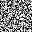

In [260]:
import imageio
import numpy as np
from torchvision.transforms import ToPILImage
import torch
from IPython.display import Image as IPyImage, display

to_pil = ToPILImage()

random_index = 4
frames = []

for i in range(timesteps-1):
    img_array = samples[i][random_index]  # assumed shape [C, H, W]

    if isinstance(img_array, np.ndarray):
        img_array = (img_array + 1) / 2
        img_array = np.clip(img_array, 0, 1)
        img_tensor = torch.from_numpy(img_array)
    else:
        img_tensor = (img_array + 1) / 2
        img_tensor = img_tensor.clamp(0, 1)

    img = to_pil(img_tensor)
    frames.append(np.array(img))

gif_path = "diffusion.gif"
imageio.mimsave(gif_path, frames, duration=0.05)

display(IPyImage(filename="diffusion.gif", width=512, height=512))

### The code file should follow the format "HW\{\#assignment\}\_\{id\}.\{extension\}" (according to the course syllabus).
